# 📈 Portfolio Optimization with Modern Portfolio Theory (MPT)

Welcome! In this project, we’ll build an optimized stock portfolio using **Modern Portfolio Theory**.

This notebook is designed for beginners, with step-by-step explanations.

## 🎯 Objective
We aim to:
- Download stock data
- Calculate returns and risk
- Simulate portfolios
- Identify the best one using the **Sharpe Ratio**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

%matplotlib inline

## 💼 Step 1: Choose Your Stocks

In [22]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']  # You can customize this list

In [23]:
from datetime import datetime, timedelta

end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)  # Get five years of data
print(start_date)

2015-10-20 16:32:06.252079


## 📥 Step 2: Download Historical Data

In [24]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    # Use 'Close' column instead of 'Adj Close'
    adj_close_df[ticker] = data['Close']

C:\Users\Krishna Bhardwaj\AppData\Local\Temp\ipykernel_74292\2590663921.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Krishna Bhardwaj\AppData\Local\Temp\ipykernel_74292\2590663921.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Krishna Bhardwaj\AppData\Local\Temp\ipykernel_74292\2590663921.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Krishna Bhardwaj\AppData\Local\Temp\ipykernel_74292\2590663921.py:3: FutureWarning: YF.download() has changed argument auto_adjust de

In [25]:
print(adj_close_df)

                  AAPL        MSFT       GOOGL        AMZN        META
Date                                                                  
2015-10-20   25.567026   41.625629   33.767109   28.044001   96.405678
2015-10-21   25.564774   41.128952   33.359909   27.788500   96.515022
2015-10-22   25.955801   41.852180   33.823715   28.195499   99.059326
2015-10-23   26.760321   46.069660   35.720139   29.951500  101.563889
2015-10-26   25.906366   47.272156   36.305599   30.430500  103.134201
...                ...         ...         ...         ...         ...
2025-10-10  245.270004  510.959991  236.570007  216.369995  705.299988
2025-10-13  247.660004  514.049988  244.149994  220.070007  715.700012
2025-10-14  247.770004  513.570007  245.449997  216.389999  708.650024
2025-10-15  249.339996  513.429993  251.029999  215.570007  717.549988
2025-10-16  247.449997  511.609985  251.460007  214.470001  712.070007

[2513 rows x 5 columns]


## 📥 Step 3: Calculate Lognormal Returns 

In [26]:
# I would recommend using the lognormal ret. because they are additive for future calculations 
log_returns = np.log(adj_close_df / adj_close_df.shift(1))


Drop any missing values 

In [27]:
log_return = log_returns.dropna()  

## 📊 Step 4: Calculate Mean Returns and Covariance

## Calculating Covariance Matrix Using annualized log returns 

In [28]:
cov_matrix = log_return.cov() * 252  
print("\nAnnualized Covariance Matrix:\n")
print(cov_matrix)


Annualized Covariance Matrix:

           AAPL      MSFT     GOOGL      AMZN      META
AAPL   0.085076  0.053449  0.051463  0.055155  0.058915
MSFT   0.053449  0.072480  0.055660  0.059313  0.062254
GOOGL  0.051463  0.055660  0.082317  0.061042  0.069012
AMZN   0.055155  0.059313  0.061042  0.106906  0.077727
META   0.058915  0.062254  0.069012  0.077727  0.149782


In [29]:
# Calculate daily and annual returns
mean_daily_returns = log_return.mean()
mean_annual_returns = mean_daily_returns * 252  # Annualize the returns (252 trading days)

print("Daily Mean Returns:\n", mean_daily_returns)
print("\nAnnualized Mean Returns:\n", mean_annual_returns)


Daily Mean Returns:
 AAPL     0.000904
MSFT     0.000999
GOOGL    0.000799
AMZN     0.000810
META     0.000796
dtype: float64

Annualized Mean Returns:
 AAPL     0.227713
MSFT     0.251684
GOOGL    0.201419
AMZN     0.204087
META     0.200598
dtype: float64


## ⚙️ Step 5: Define Portfolio Performance Functions/Metrics 

In [30]:
def standard_deviation(weights, cov_matrix): #Calculate the portfolio standard deviation
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns): #Calculate expected return
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate): #Calculate Sharpe Ratio 
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

## 🚧 Step 6: Optimization Constraints

In [31]:
# We set the risk-free rate, define a function to minimize the negative Sharpe ratio, and set constraints and bounds for the optimization process
risk_free_rate = .02

In [32]:
# Install and import fredapi, then initialize FRED
%pip install fredapi

from fredapi import Fred

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='0a81ac97eaecad3c384b5aec7cda85c9')
ten_year_treasury = fred.get_series_latest_release('DGS10') / 100  # Convert percentage to decimal

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Set the risk-free rate 
risk_free_rate = ten_year_treasury.iloc[-1]  # Use the latest available value
print(risk_free_rate)

0.0405


## 🚀 Step 7: Optimize the Portfolio

In [34]:

#Define the negative Sharpe ratio function for minimization

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [35]:
# Set constraints and bounds for optimization
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))] # (0)No short selling, (0.4)max 40% in any asset

In [36]:
# Initial Rates for weights
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [37]:
# Optimize the weights to maximize the Sharpe ratio
# 'SLSQP' Stands for Sequential Least Squares Quadratic Programming, which is a numerical optimization technique suitable for solving nolinear optimization problems with constraints.
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [38]:
# Get the Optimal Weights
optimal_weights = optimized_results.x

## 🚀 Step 8: Analyze The Optimal Portfolio 

In [39]:
# Display analytics of the optimal portfolio

optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AAPL: 0.4000
MSFT: 0.4000
GOOGL: 0.1664
AMZN: 0.0336
META: 0.0000
Expected Annual Return: 0.2321
Expected Volatility: 0.2505
Sharpe Ratio: 0.7651


## ✅ Step 8: Show Optimized Portfolio

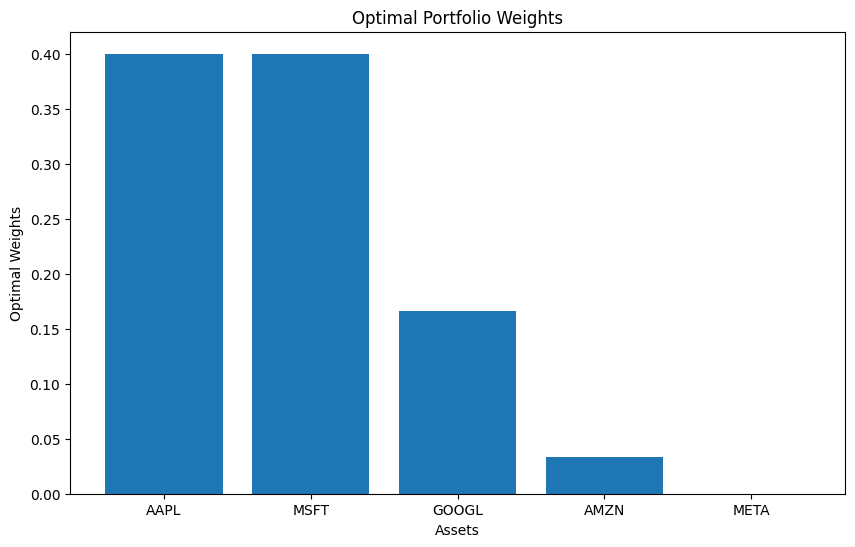

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

## 🧠 Conclusion

You just created an optimized portfolio using **Modern Portfolio Theory**!

You learned to:
- Download and analyze stock data
- Calculate return & risk
- Maximize the Sharpe Ratio 🚀

Try it with different stocks or time ranges for more insights.